

<h3>Problem statement</h3>
Predict Published relative CPU performance of CPU models.

In this project we will use various predictive models to see how accurate they are in predicting the published relative CPU performance of different CPU models.We will also analyse the data and find out the features which have high impact on the CPU performance.

Data Attributes as per dataset:
1. <b>Vendor name</b>: Name of the manufacturer 
      
 (adviser, amdahl,apollo, basf, bti, burroughs, c.r.d, cambex, cdc, dec, dg, formation, four-phase, gould, honeywell, hp, ibm,  ipl, magnuson,microdata, nas, ncr, nixdorf, perkin-elmer, prime, siemens, sperry,sratus, wang)
   
2. <b>Model Name</b>: CPU models
   
3. <b>MYCT</b>: machine cycle time in nanoseconds (integer)
  
4. <b>MMIN</b>: minimum main memory in kilobytes (integer)
   
5. <b>MMAX</b>: maximum main memory in kilobytes (integer)
   
6. <b>CACH</b>: cache memory in kilobytes (integer)
   
7. <b>CHMIN</b>: minimum channels in units (integer)
  
8. <b>CHMAX</b>: maximum channels in units (integer)
  
9. <b>PRP</b>: published relative performance (integer)
  
10. <b>ERP</b>: estimated relative performance from the original article (integer)

We are going to predict the PRP variable.In our data set you can find the Published Relative Performance benchmarks (PRP), from the influential BYTE magazine, for 209 FDA Approved CPUs . ERP values or estimated benchmark performance have been calculated by  Tel Aviv university.We wont include ERP values while trainig our data.  

<b>Initial Assumptions:</b>
 - The factors which affects a CPU performance are mainly RAM capacity,Cache memory capacity,Cycle time,clock speed etc. 
 - Our dataset has memory ,cache ,cycle time features and we will find out if they really influence the CPU performace of our models  in the dataset.

We will perform following steps in this project:

1.Initial data analysis<br/>
2.Exploratory data analysis<br/>
4.Feature Engineering<br/>
4.Model training and testing<br/>
5.Hyperparameter tuning<br/>
6.ModelSelection

<h3>Insights</h3><br/>
1.High memory capacity and low machine cycle time helps to achieve high CPU performance.This confirms our initial assumptions.<br/>
2.Outliers in the dataset indicate that there are few models which are premium products having high memory capacity and low machine cycle time, and exhibit high CPU performance.<br/>
3.Premium models were manufactured by AMDAHL,NAS and SPERRY.<br/>
4.IBM produced largest number of models but lacked high CPU performance.<br/>
5.RandomForest gave the best RMSE score 38% among other models.Normalisation and Hyperparameter tuning using GridSearch helped to improve the score.<br/>
6.Dataset could have included more CPU related features to help in prediction.


In [22]:

import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

# Sklearn libraries
from sklearn import linear_model
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge

from scipy.stats import norm,skew, kurtosis
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings('ignore')
bold='\033[1m'

In [23]:
#Acquire data
df_cpu = pd.read_csv('C:/Users/StephyJosin/Desktop/projects/CPU/machine.csv')

<h3>Initial Analysis</h3>

In [24]:
def preview_data(df):   

    #preview dataset
    print(bold+"Top 5 rows:\n\n",df.head())
    print(bold+"\nLast 5 rows:\n\n",df.tail())

    # Make a backup copy
    df_cpu_cpy = df.copy()
    
    #Columns available in dataset
    print(bold+"\nAttributes of the dataset\n", df.columns.values)
    
    #Dimensions of the dataset
    print(bold+"\nNo of rows:", df.shape[0])
    print(bold+"No of columns:", df.shape[1])
    
    #View the datatypes
    df.info()
    
    #Check for missing values
    print(bold+"\nMissing values in the dataset:",df.isnull().sum().max())

In [25]:
preview_data(df_cpu)

Top 5 rows:

     Vendor    Model  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0  adviser    32/60   125   256   6000   256     16    128  198  199
1   amdahl   470v/7    29  8000  32000    32      8     32  269  253
2   amdahl  470v/7a    29  8000  32000    32      8     32  220  253
3   amdahl  470v/7b    29  8000  32000    32      8     32  172  253
4   amdahl  470v/7c    29  8000  16000    32      8     16  132  132

Last 5 rows:

      Vendor          Model  MYCT  MMIN  MMAX  CACH  CHMIN  CHMAX  PRP  ERP
204  sperry           80/8   124  1000  8000     0      1      8   42   37
205  sperry  90/80-model-3    98  1000  8000    32      2      8   46   50
206  sratus             32   125  2000  8000     0      2     14   52   41
207    wang         vs-100   480   512  8000    32      0      0   67   47
208    wang          vs-90   480  1000  4000     0      0      0   45   25

Attributes of the dataset
 ['Vendor' 'Model' 'MYCT' 'MMIN' 'MMAX' 'CACH' 'CHMIN' 'CHMAX' 'PRP' 'ERP']

No

<b>Observations:</b><br/>
-There are no missing values in the dataset.<br/>
-There are 2 Categorical variables<br/>
   -Vendor,Model<br/>
-There are 8 Numerical variables<br/>
   -MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP<br/>
-PRP is our Target variable<br/>
-ERP is considered as as target Reference field


In [26]:
def summary_stat():
    
    print("--"*40)    
    print(bold+"Summary Statistics of numeric features:" )
    print("--"*40)
    print(df_cpu.describe())
    print("--"*40)
    print(bold+"Summary Statistics of categorical features:")
    print("--"*40)
    print(df_cpu.describe(include=['O']))
       

In [27]:
summary_stat() 

--------------------------------------------------------------------------------
Summary Statistics of numeric features:
--------------------------------------------------------------------------------
              MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            CHMAX          PRP          ERP  
count  209.000000   209.000000   209.000000  
mean    18.267943   105.622010    99.33

<b>Observations:</b><br/>

-Relative performance(PRP) is not zero for any model<br/>
-Cache memory,Minimum Channels and Maximum Channels are zero for some models.<br/>
-Numerical feature seems to have extreme values and distribution doesnt look normal.<br/>
-There are 30 vendors and IBM have highest number of CPU models.<br/>
-There are no duplicate CPU models.<br/>
   


 

<h3>Exploratory Data Analysis</h3>

We will analyse our target variable first i.e Pubished Relative performance(PRP)<br/>

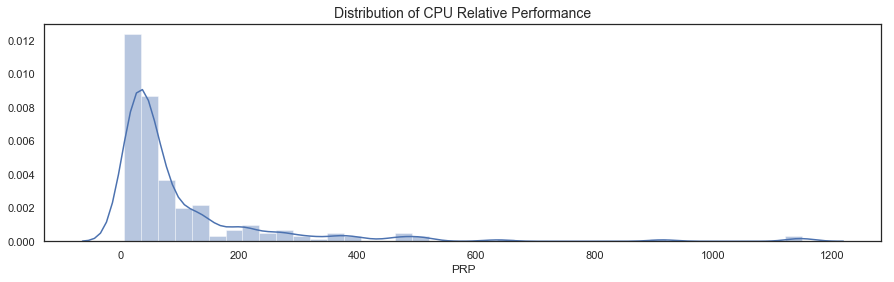

In [28]:
fig, ax = plt.subplots(figsize=(15,4))
sns.distplot(df_cpu["PRP"])
ax.set_title('Distribution of CPU Relative Performance', fontsize=14)
plt.show()



<b>Observations:</b><br/>
 -PRP data is not normally distributed and its highly skewed to left.<br/>
 -Most of the CPU models have performance ranging from 5 to 100.Very few models exhibit higher performance.Those few models could be the expensive models while others are the budget models. 
 

In [29]:
df_high_PRP=df_cpu[df_cpu["PRP"]>500]
df_high_PRP.head()

,Vendor,Model,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
8,amdahl,580-5860,23,16000,64000,64,16,32,636,749
9,amdahl,580-5880,23,32000,64000,128,32,64,1144,1238
153,nas,as/9000-dpc,38,16000,32000,128,16,32,510,426
156,nas,as/9060,30,16000,32000,256,16,24,510,603
198,sperry,1100/93,30,8000,64000,96,12,176,915,919


<b>Observations:</b><br/>
- Models with large main memory ,cache memory,maximum channels and low machine cycle time exhibit high CPU performance.
- Highest performance models are few as they are premium products and they are manufactured mainly by AMDAHL,NAS and SPERRY.

Next we will plot a <b>correlation matrix</b> using heatmap to view the relationship between PRP and other numeric features<br/>

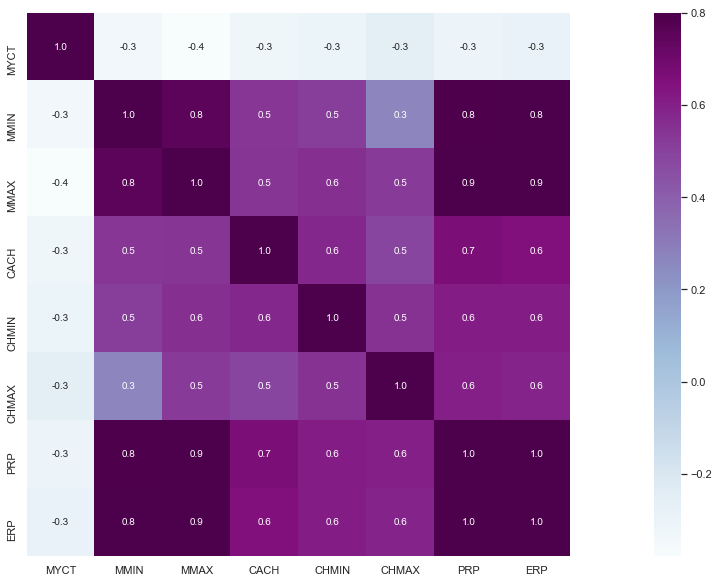

In [30]:
df_cpu_numeric=df_cpu.select_dtypes(exclude=['object'])
def plot_corr_heatmp():
    corr = df_cpu_numeric.corr()
    fig = plt.figure(figsize=(30, 10))
    sns.heatmap(corr, vmax=.8, square=True, cmap="BuPu",annot=True,fmt=".1f",annot_kws={'size': 10});
    plt.show()
    
plot_corr_heatmp()    

<b>Observations:</b><br/>
1.These are the variables having strong postive correlation with PRP.<br/>
    ->ERP                      -1<br/>
    ->Maximum main memory(MMAX)-0.9<br/>
    ->Minimum main memory(MMIN)-0.8<br/>
    ->Cache memory(CACH)       -0.7<br/>
    ->Minimum channels(CHMIN)  -0.6<br/>
    ->Maximum channels(CHMAX)  -0.6<br/><br/>

2.MYCT is weakly corelated with PRP.<br/>
  ->Machine cycle time(MYCT)- -0.3 <br/>
  
3.Maximum main memory(MMAX) and Minimum main memory(MMIN) are highly correlated with each other.Since they are the strong predictors i will keep both the features.

This confirms one of our assumption that memory related features have high impact on the CPU performance.<br/>Also lower the machine cycle time higher the CPU performance.


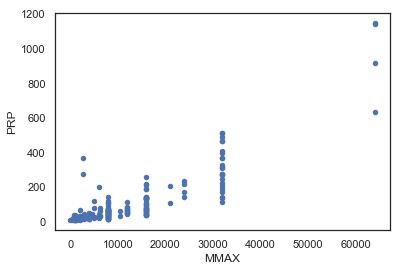

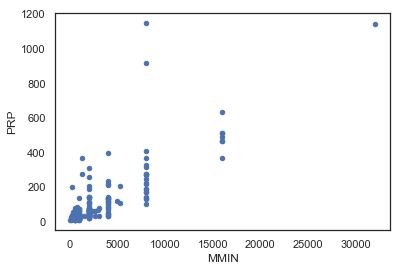

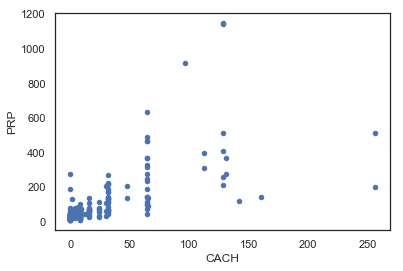

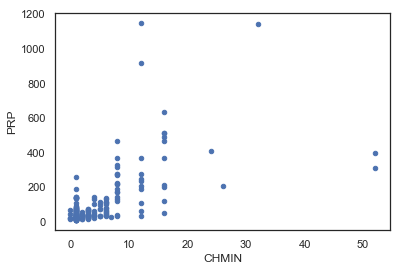

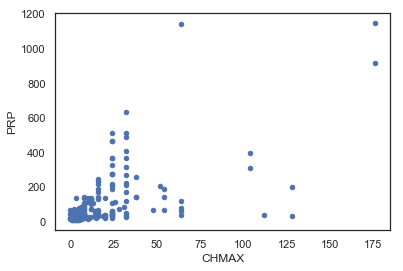

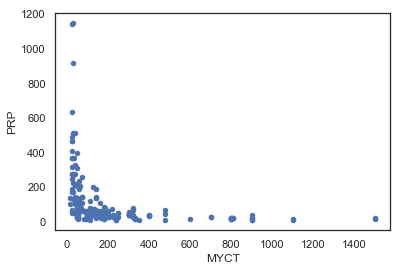

In [31]:
def plot_scatter_numeric():
    df_cpu.plot.scatter(x='MMAX', y='PRP');
    df_cpu.plot.scatter(x='MMIN', y='PRP');
    df_cpu.plot.scatter(x='CACH', y='PRP');
    df_cpu.plot.scatter(x='CHMIN', y='PRP');
    df_cpu.plot.scatter(x='CHMAX', y='PRP');
    df_cpu.plot.scatter(x='MYCT', y='PRP');
    
plot_scatter_numeric()

<b>Observations</b><br/>

-Above scatterplot confirms the heatmap findings.<br/>
-Also we can see that features are highly skewed and there are outliers in the data.<br/>
-Plot shows that there is no clear positive correlation between the memory predictors and the CPU performance.This is because CPU  performance depends mainly on combination of memory capacity and machine cycle time values.For eg:-If the Main memory capacity of a model is high ,but the machine cycle time is also high ,then performane of CPU will be reduced.<br/>
-However MYCT ,though it had weak correlation with PRP in our heatmap,here shows a stronger negative correlation with PRP.This implies that machine cycle time(MYCT) is in fact an important feature to predict CPU performance.<br/><br/>



We will analyse the categorical variables 'Vendor' and 'Model' and how these features influence the CPU Performance.

Text(0.5,1,'No of CPU Models per Vendor')

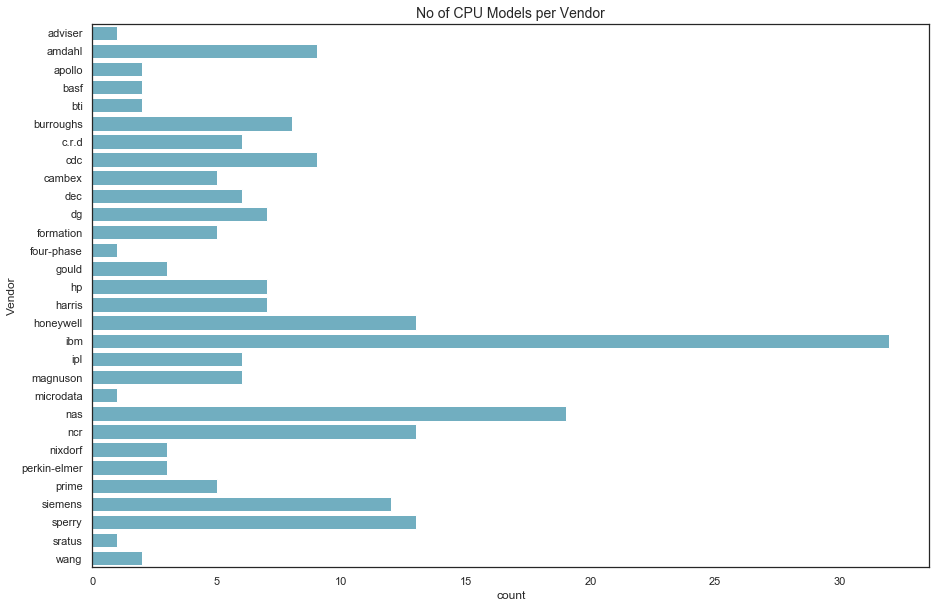

In [32]:

f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y="Vendor", data=df_cpu, color="c");
ax.set_title('No of CPU Models per Vendor', fontsize=14)

Plot shows that IBM,nas,sperry are the largest manufacturers of CPUs.IBM has 32 CPU models in the dataset.<br/>
Now we will see who manufactures CPUs with higher performance.


Text(0.5,1,'Vendor vs CPU performance')

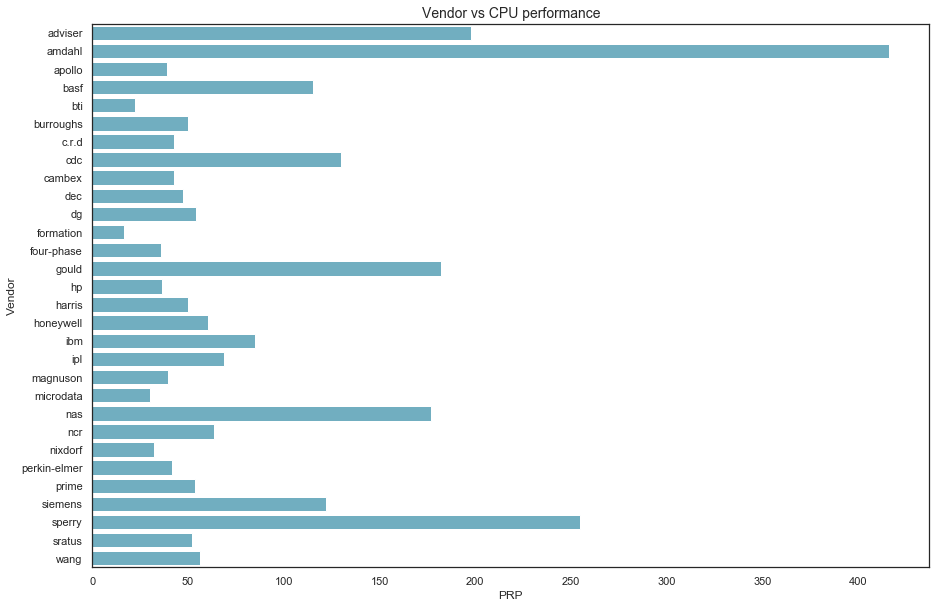

In [33]:
#Plot vendors against CPU performance
f, ax = plt.subplots(figsize=(15, 10))
# sns.countplot(x="PRP",y="Vendor", data=df_cpu, color="c");
ax = sns.barplot(x="PRP",y="Vendor", data=df_cpu, color="c",ci=None)
ax.set_title('Vendor vs CPU performance', fontsize=14)

<b>Observations:</b><br/>
    -Though IBM is the largest manfacturer of CPU models,AMDAHL models exhibit highest CPU performance followed by sperry and   advisor.<br/>
    -Formation models have least CPU performance.
    

<h3>Feature Engineering</h3>

In this step , we are going to :<br/>
    -Log transform skewed features to normalise the values.<br/>
    -Dummy encode categorical variables.

In [34]:
def plot_target(target):
    sns.distplot(target, fit=norm);
    fig = plt.figure()
    res = stats.probplot(target, plot=plt)


def remove_skew(df):
    
    #skewed features
    numeric_feats = df.dtypes[df.dtypes !='object'].index
    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    print(skewness.head(20))
 
    skewness = skewness[abs(skewness) > 0.5]
    print("There are {} skewed numerical features to log transform".format(skewness.shape[0]))

    from scipy.special import log1p
    skewed_features = skewness.index
    for feat in skewed_features:
        df[feat] = np.log1p(df[feat])


    print('\nPRP after normalisation')
    plot_target(df['PRP'])
    
    return df

def transform_features(df):
    #dummy encoding all categorical features
    text_cols = df.select_dtypes(include=['object']).columns
    print(text_cols)
    dummies=pd.get_dummies(df[text_cols])
    print(dummies)
    df = pd.concat([df, dummies], axis=1) 
    df=df.drop(text_cols,axis=1)
    
    return df
    



Skew in numerical features: 

           Skew
CHMIN  3.998371
PRP    3.864820
CHMAX  3.570046
MMIN   3.490649
CACH   2.804463
MYCT   2.525857
MMAX   2.125268
There are 7 skewed numerical features to log transform

PRP after normalisation


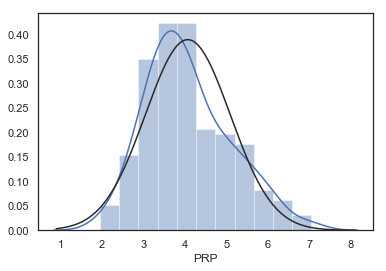

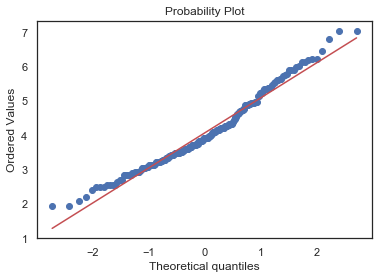

In [35]:
def Pre_Process(df):
    #Drop Vendor and Model columns as they doesnt have impact on the CPU performance.
    #This is evident from the feature important graph of random forest.
    df_cpu_numeric=df.drop(["Vendor","Model","ERP"], axis = 1)
    df_unskewed=remove_skew(df_cpu_numeric)
    return df_cpu_numeric

df_cpu=Pre_Process(df_cpu)

<h3>Model Training</h3>

We will train our model using Regularised Linear models ,Gradientboosting and Randomforest models.

In [36]:
# Split our dataframe into a training (75%) and test (25%) set.
predictors = df_cpu.drop(["PRP"], axis=1).columns
CPU_train, CPU_test = train_test_split(df_cpu, test_size=0.25,random_state=111)


print(bold+"Training data dimension:",CPU_train.shape)
print(bold+"Testing data dimension:",CPU_test.shape)


Training data dimension: (156, 7)
Testing data dimension: (53, 7)


<b>Training and Testing different models</b>

--------------------------------------------------------------------------------
Model: KernelRidge

Training RMSE: 46.07243502886658

Testing RMSE: 43.4611603078696
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: ElasticNet

Training RMSE: 65.67135136540465

Testing RMSE: 66.94044088469595
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: Lasso

Training RMSE: 83.18277638599947

Testing RMSE: 83.89971816665005
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: GradientBoostingRegressor

Training RMSE: 40.73098778957393

Testing RMSE: 39.79440646600884
--------------------------------------------------------------------------------

F

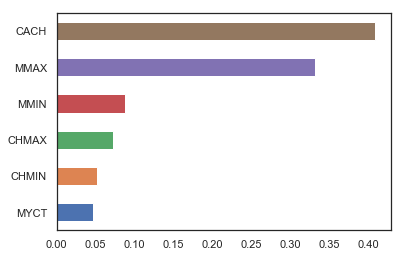

In [37]:
def train_test(df_train,df_test):
    '''
    This function performs :
    -cross validation of different models on training data 
    -predicts the test data PRP.
    -Calculate RMSE value.
    -Show feature importances using Randomforest models
    '''
    
    target="PRP"  
    X_train=df_train[predictors]
    Y_train=df_train[target]
    X_test=df_test[predictors]
    Y_test=df_test[target]
    
    shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=111)
    
    rmse_values = []
    
    clf_rf=RandomForestRegressor()
    models = [KernelRidge(), 
              ElasticNet(), Lasso(),
              GradientBoostingRegressor(),
              clf_rf]

    for alg in models:

        #set name and parameters
        model_name = alg.__class__.__name__
      
        alg.fit(X_train, Y_train)
        #score model with cross validation:      
        training_results =np.sqrt((-cross_val_score(alg, X_train, Y_train, cv = shuff, scoring= 'neg_mean_squared_error')).mean())
       
        test_results = np.sqrt(((Y_test-alg.predict(X_test))**2).mean())

        #Feature importances
        
        if alg == clf_rf:
            print("\nFeature Importances\n")
            print("--"*40)
            importances = alg.feature_importances_
            features = pd.Series(importances,
                             index=X_train[predictors].columns.values)
            features.sort_values()[-10:].plot(kind = 'barh')

        print("--"*40)
        print(bold+"Model:",model_name)
        print(bold+"\nTraining RMSE:",training_results*100)
        print(bold+"\nTesting RMSE:",test_results*100)
        print("--"*40)
        
train_test(CPU_train,CPU_test)

<h3>HyperParameter Tuning</h3>

We will consider Gradientboosting and Randomforest models for optimization.GridsearchCV technique will be applied on each model to find best score.

In [38]:
def Optimize_model(df_train,df_test):
    
    target="PRP"  
    X_train=df_train[predictors]
    Y_train=df_train[target]
    X_test=df_test[predictors]
    Y_test=df_test[target]
    
    clf_rf=RandomForestRegressor()
    clf_gb=GradientBoostingRegressor()
    models = [clf_gb,clf_rf]
    
    shuff = ShuffleSplit(n_splits=5, test_size=0.2, random_state=111)
    
    
    GB_param_grid = {'loss': ['huber'], 'learning_rate': [0.1], 'n_estimators': [30], 'max_depth': [3], 
                                            'min_samples_split': [0.0025], 'min_samples_leaf': [5]}
    RFR_param_grid = {'n_estimators': [130], 'max_features': ['auto'], 'max_depth': [8], 'min_samples_split': [5], 'min_samples_leaf': [2]}

    params_grid = [ GB_param_grid,  RFR_param_grid]


    row_index = 0
    for alg in models:

        gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'neg_mean_squared_error', n_jobs=-1)
        params_grid.pop(0)

        #set name and parameters
        model_name = alg.__class__.__name__

        gs_alg.fit(X_train, Y_train)
        gs_best = gs_alg.best_estimator_

        #score model with cross validation: 
        after_training_results = np.sqrt(-gs_alg.best_score_)
        after_test_results = np.sqrt(((Y_test-gs_alg.predict(X_test))**2).mean())

        print("--"*40)
        print(bold+"Model:",model_name)
        print(bold+"\nTraining RMSE:",after_training_results*100)
        print(bold+"\nTesting RMSE:",after_test_results*100)
        print("--"*40)
        
    

In [39]:
Optimize_model(CPU_train,CPU_test)

--------------------------------------------------------------------------------
Model: GradientBoostingRegressor

Training RMSE: 41.05826552431352

Testing RMSE: 42.495458678020285
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Model: RandomForestRegressor

Training RMSE: 40.423940324808996

Testing RMSE: 38.74394141967369
--------------------------------------------------------------------------------


<h3>Conclusion</h3>

1.High memory capacity and low machine cycle time helps to achieve high CPU performance.<br/>
2.Outliers in the dataset indicate that there are few models which are premium products having high memory capacity and low machine cycle time, and exhibit high CPU performance.<br/>
3.Premium models were manufactured by AMDAHL,NAS and SPERRY.<br/>
4.IBM produced largest number of models but lacked high CPU performance.<br/>
6.RandomForest gave the best RMSE score 38% among other models.Normalisation and Hyperparameter tuning using GridSearch helped to slightly improve the score.<br/>
7.Dataset could have included more CPU related features to do more feature engineering.<br/>